# Build a linear model with estimators
***

In [1]:
import tensorflow as tf

In [2]:
import tensorflow.feature_column as fc

import os
import sys

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
tf.enable_eager_execution()

## Download official implementation
***

! conda install -q requests ***(Install this through conda instead)***

In [4]:
! git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Counting objects: 2832, done.
remote: Compressing objects: 100% (2468/2468), done.
remote: Total 2832 (delta 475), reused 1678 (delta 293), pack-reused 0
Receiving objects: 100% (2832/2832), 389.81 MiB | 3.39 MiB/s, done.
Resolving deltas: 100% (475/475), done.


In [5]:
models_path = os.path.join(os.getcwd(), 'models')

sys.path.append(models_path)

In [6]:
from official.wide_deep import census_dataset
from official.wide_deep import census_main

census_dataset.download("/tmp/census_data")

#### Command line usage

In [7]:
#export PYTHONPATH=${PYTHONPATH}:"${pwd}/models"

if "PYTHONPATH" in os.environ:
    print ("'PYTHONPATH' is in os.environ ")
    os.environ['PYTHONPATH'] += os.pathsep + models_path
else:
    print ("'PYTHONPATH' was not in os.environ ")
    os.environ['PYTHONPATH'] = models_path 

'PYTHONPATH' was not in os.environ 


In [8]:
#!python -m official.wide_deep.census_main --help

In [9]:
#!python -m official.wide_deep.census_main --model_type=wide --train_epochs=2

## Read US Census Data
***

In [10]:
train_file = "/tmp/census_data/adult.data"
test_file = "/tmp/census_data/adult.test"

In [11]:
import pandas

In [12]:
train_df = pandas.read_csv(train_file,
                           header=None,
                           names=census_dataset._CSV_COLUMNS)
test_df = pandas.read_csv(test_file,
                          header=None,
                          names=census_dataset._CSV_COLUMNS)

In [13]:
train_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


These features are both categorical and continuous

## Converting Data into Tensors
***

In [14]:
def easy_input_function(df, label_key, num_epochs,
                        shuffle, batch_size):
    label = df[label_key]
    ds = tf.data.Dataset.from_tensor_slices((dict(df), label))
    
    if shuffle:
        ds = ds.shuffle(10000)
        
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    return ds

In [15]:
ds = easy_input_function(train_df, label_key='income_bracket',
                         num_epochs=5, shuffle=True, batch_size=10)

for feature_batch, label_batch in ds.take(1):
    print('Some feature Keys:', list(feature_batch.keys())[:5])
    print()
    print('A batch of Ages  :', feature_batch['age'])
    print()
    print('A batch of Labels:', label_batch)

Some feature Keys: ['age', 'workclass', 'fnlwgt', 'education', 'education_num']

A batch of Ages  : tf.Tensor([24 38 23 19 34 18 31 35 47 43], shape=(10,), dtype=int32)

A batch of Labels: tf.Tensor(
[b'<=50K' b'<=50K' b'<=50K' b'<=50K' b'>50K' b'<=50K' b'<=50K' b'>50K'
 b'<=50K' b'>50K'], shape=(10,), dtype=string)


In [18]:
import inspect
print (inspect.getsource(census_dataset.input_fn))

def input_fn(data_file, num_epochs, shuffle, batch_size):
  """Generate an input function for the Estimator."""
  assert tf.gfile.Exists(data_file), (
      '%s not found. Please make sure you have run census_dataset.py and '
      'set the --data_dir argument to the correct path.' % data_file)

  def parse_csv(value):
    tf.logging.info('Parsing {}'.format(data_file))
    columns = tf.decode_csv(value, record_defaults=_CSV_COLUMN_DEFAULTS)
    features = dict(zip(_CSV_COLUMNS, columns))
    labels = features.pop('income_bracket')
    classes = tf.equal(labels, '>50K')  # binary classification
    return features, classes

  # Extract lines from input files using the Dataset API.
  dataset = tf.data.TextLineDataset(data_file)

  if shuffle:
    dataset = dataset.shuffle(buffer_size=_NUM_EXAMPLES['train'])

  dataset = dataset.map(parse_csv, num_parallel_calls=5)

  # We call repeat after shuffling, rather than before, to prevent separate
  # epochs from blending together.
  dataset = 

In [19]:
ds = census_dataset.input_fn(train_file, num_epochs=5, shuffle=True,
                            batch_size=10)

for feature_batch, label_batch in ds.take(1):
  print('Feature keys:', list(feature_batch.keys())[:5])
  print()
  print('Age batch   :', feature_batch['age'])
  print()
  print('Label batch :', label_batch )

INFO:tensorflow:Parsing /tmp/census_data/adult.data


I0810 15:30:05.850450 140736019358592 tf_logging.py:115] Parsing /tmp/census_data/adult.data


Feature keys: ['age', 'workclass', 'fnlwgt', 'education', 'education_num']

Age batch   : tf.Tensor([31 65 41 21 38 39 29 62 38 22], shape=(10,), dtype=int32)

Label batch : tf.Tensor([False False False False  True False  True  True False False], shape=(10,), dtype=bool)


In [20]:
import functools

train_inpf = functools.partial(census_dataset.input_fn, train_file,
                               num_epochs=2, shuffle=True, batch_size=64)
test_inpf = functools.partial(census_dataset.input_fn, test_file,
                              num_epochs=1, shuffle=False, batch_size=64)

## Selecting and Engineering Features for the Model

In [22]:
age = fc.numeric_column('age')

In [23]:
print(age)

_NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)


In [24]:
fc.input_layer(feature_batch, [age]).numpy()

array([[31.],
       [65.],
       [41.],
       [21.],
       [38.],
       [39.],
       [29.],
       [62.],
       [38.],
       [22.]], dtype=float32)

In [25]:
classifier = tf.estimator.LinearClassifier(feature_columns=[age])
classifier.train(train_inpf)
result = classifier.evaluate(test_inpf)

clear_output()
print(result)

{'accuracy': 0.76352805, 'accuracy_baseline': 0.76377374, 'auc': 0.6782144, 'auc_precision_recall': 0.3113379, 'average_loss': 0.5257737, 'label/mean': 0.23622628, 'loss': 33.569107, 'precision': 0.35714287, 'prediction/mean': 0.21316682, 'recall': 0.001300052, 'global_step': 1018}


In [27]:
education_num = tf.feature_column.numeric_column('education_num')
capital_gain = fc.numeric_column('capital_gain')
capital_loss = tf.feature_column.numeric_column('capital_loss')
hours_per_week = fc.numeric_column('hours_per_week')

my_numeric_columns = [age, education_num, capital_gain, capital_loss, hours_per_week]

fc.input_layer(feature_batch, my_numeric_columns).numpy()

array([[31.,  0.,  0., 14., 45.],
       [65.,  0.,  0.,  4., 50.],
       [41.,  0.,  0.,  9., 40.],
       [21.,  0.,  0., 10., 10.],
       [38.,  0.,  0.,  9., 40.],
       [39.,  0.,  0.,  9., 40.],
       [29.,  0.,  0., 10., 40.],
       [62.,  0.,  0., 13., 50.],
       [38.,  0.,  0., 13., 56.],
       [22.,  0.,  0.,  9., 16.]], dtype=float32)

In [28]:
classifier = tf.estimator.LinearClassifier(feature_columns=my_numeric_columns)
classifier.train(train_inpf)

result = classifier.evaluate(test_inpf)

clear_output()

for key, value in sorted(result.items()):
    print ('%s: %s' % (key, value))

accuracy: 0.78140163
accuracy_baseline: 0.76377374
auc: 0.8038529
auc_precision_recall: 0.5646555
average_loss: 1.1049582
global_step: 1018
label/mean: 0.23622628
loss: 70.54833
precision: 0.56882495
prediction/mean: 0.37562495
recall: 0.30837235


### Categorical Columns

In [29]:
relationship = fc.categorical_column_with_vocabulary_list(
    'relationship',
    ['Husband', 'Not-in-family', 'Wife', 'Own-child',
     'Unmarried', 'Other-relative']
)

In [30]:
fc.input_layer(feature_batch, [age, fc.indicator_column(relationship)])

<tf.Tensor: id=4366, shape=(10, 7), dtype=float32, numpy=
array([[31.,  1.,  0.,  0.,  0.,  0.,  0.],
       [65.,  0.,  0.,  0.,  0.,  1.,  0.],
       [41.,  1.,  0.,  0.,  0.,  0.,  0.],
       [21.,  0.,  0.,  0.,  1.,  0.,  0.],
       [38.,  1.,  0.,  0.,  0.,  0.,  0.],
       [39.,  0.,  1.,  0.,  0.,  0.,  0.],
       [29.,  0.,  0.,  1.,  0.,  0.,  0.],
       [62.,  1.,  0.,  0.,  0.,  0.,  0.],
       [38.,  1.,  0.,  0.,  0.,  0.,  0.],
       [22.,  0.,  0.,  0.,  1.,  0.,  0.]], dtype=float32)>

In [31]:
occupation = tf.feature_column.categorical_column_with_hash_bucket('occupation',
                                                                   hash_bucket_size=1000)

In [32]:
for item in feature_batch['occupation'].numpy():
    print(item.decode())

Prof-specialty
Farming-fishing
Machine-op-inspct
?
Machine-op-inspct
Exec-managerial
Adm-clerical
Prof-specialty
Adm-clerical
Handlers-cleaners


In [36]:
occupation_result = fc.input_layer(feature_batch, [fc.indicator_column(occupation)])
occupation_result.numpy().shape

(10, 1000)

In [40]:
tf.arg_max(occupation_result, dimension=1).numpy()

array([979, 936, 911,  65, 911, 800,  96, 979,  96,  10])

In [41]:
education = tf.feature_column.categorical_column_with_vocabulary_list(
    'education', [
        'Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
        'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
        '5th-6th', '10th', '1st-4th', 'Preschool', '12th'])

marital_status = tf.feature_column.categorical_column_with_vocabulary_list(
    'marital_status', [
        'Married-civ-spouse', 'Divorced', 'Married-spouse-absent',
        'Never-married', 'Separated', 'Married-AF-spouse', 'Widowed'])

workclass = tf.feature_column.categorical_column_with_vocabulary_list(
    'workclass', [
        'Self-emp-not-inc', 'Private', 'State-gov', 'Federal-gov',
        'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked'])


my_categorical_columns = [relationship, occupation, education, marital_status, workclass]

In [42]:
classifier = tf.estimator.LinearClassifier(
    feature_columns=my_numeric_columns+my_categorical_columns)

classifier.train(train_inpf)
result = classifier.evaluate(test_inpf)

clear_output()

for key, value in sorted(result.items()):
    print('{}: {}'.format(key, value))

accuracy: 0.8431914448738098
accuracy_baseline: 0.7637737393379211
auc: 0.8921357989311218
auc_precision_recall: 0.7352809906005859
average_loss: 0.3496234118938446
global_step: 1018
label/mean: 0.23622627556324005
loss: 22.322425842285156
precision: 0.6898678541183472
prediction/mean: 0.23766247928142548
recall: 0.6107644438743591


### Bucketing

In [44]:
age_buckets = tf.feature_column.bucketized_column(
    age, boundaries=[18,25,30,35,40,45,50,55,60,65])

In [45]:
fc.input_layer(feature_batch, [age, age_buckets]).numpy()

array([[31.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [65.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [41.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [21.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [38.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [39.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [29.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [62.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [38.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [22.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],
      dtype=float32)

### Cross Columns

In [46]:
education_x_occupation = tf.feature_column.crossed_column(
    ['education', 'occupation'], hash_bucket_size=1000)

In [47]:
age_buckets_x_education_x_occupation = tf.feature_column.crossed_column(
    [age_buckets, 'education', 'occupation'], hash_bucket_size=1000)

## Define the Logistic Regression model
***

In [49]:
import tempfile

base_columns = [
    education, marital_status, relationship, workclass, occupation, age_buckets
]

crossed_columns = [
    tf.feature_column.crossed_column(
        ['education', 'occupation'], hash_bucket_size=1000),
    tf.feature_column.crossed_column(
        [age_buckets, 'education', 'occupation'], hash_bucket_size=1000)
]

model = tf.estimator.LinearClassifier(
    model_dir=tempfile.mktemp(),
    feature_columns=base_columns + crossed_columns,
    optimizer=tf.train.FtrlOptimizer(learning_rate=0.1))

INFO:tensorflow:Using default config.


I0810 16:44:20.401792 140736019358592 tf_logging.py:115] Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/fy/n6h444rd26x3b5nyrmfy_8g80000gn/T/tmpai9yzmyz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x13e8842b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0810 16:44:20.404329 140736019358592 tf_logging.py:115] Using config: {'_model_dir': '/var/folders/fy/n6h444rd26x3b5nyrmfy_8g80000gn/T/tmpai9yzmyz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x13e8842b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Train and Evaluate the Model

In [51]:
train_inpf = functools.partial(census_dataset.input_fn, train_file,
                               num_epochs=40, shuffle=True, batch_size=64)

In [53]:
model.train(train_inpf)
clear_output()

In [55]:
results = model.evaluate(test_inpf)

clear_output()

In [56]:
for key, value in sorted(results.items()):
    print('{}: {}'.format(key, value))

accuracy: 0.8354523777961731
accuracy_baseline: 0.7637737393379211
auc: 0.8815051317214966
auc_precision_recall: 0.6914873719215393
average_loss: 0.35464736819267273
global_step: 20351
label/mean: 0.23622627556324005
loss: 22.643190383911133
precision: 0.6890184879302979
prediction/mean: 0.23582811653614044
recall: 0.5530421137809753


In [61]:
for key, value in sorted(results.items()):
    print('%s: %0.2f' % (key, value))

accuracy: 0.84
accuracy_baseline: 0.76
auc: 0.88
auc_precision_recall: 0.69
average_loss: 0.35
global_step: 20351.00
label/mean: 0.24
loss: 22.64
precision: 0.69
prediction/mean: 0.24
recall: 0.55


In [70]:
for key, value in sorted(results.items()):
    print('{0}: {1:.2f}'.format(key, value))

accuracy: 0.84
accuracy_baseline: 0.76
auc: 0.88
auc_precision_recall: 0.69
average_loss: 0.35
global_step: 20351.00
label/mean: 0.24
loss: 22.64
precision: 0.69
prediction/mean: 0.24
recall: 0.55


### More detailed look at how model performed

In [72]:
import numpy as np

In [80]:
predict_df = test_df[:20].copy()

pred_iter = model.predict(
    lambda:easy_input_function(predict_df, label_key='income_bracket',
                               num_epochs=1, shuffle=False, batch_size=10))

classes = np.array(['<=50K', '>50K'])
pred_class_id = []

for pred_dict in pred_iter:
  pred_class_id.append(pred_dict['class_ids'])

predict_df['predicted_class'] = classes[np.array(pred_class_id)]
predict_df['correct'] = predict_df['predicted_class'] == predict_df['income_bracket']

clear_output()

predict_df[['income_bracket','predicted_class', 'correct']]

,income_bracket,predicted_class,correct
0,<=50K,<=50K,True
1,<=50K,<=50K,True
2,>50K,<=50K,False
3,>50K,<=50K,False
4,<=50K,<=50K,True
5,<=50K,<=50K,True
6,<=50K,<=50K,True
7,>50K,>50K,True
8,<=50K,<=50K,True
9,<=50K,<=50K,True


#### Model with L1 regularization

In [76]:
model_l1 = tf.estimator.LinearClassifier(
    feature_columns = base_columns+crossed_columns,
    optimizer = tf.train.FtrlOptimizer(
        learning_rate=0.1,
        l1_regularization_strength=10.0,
        l2_regularization_strength=0.0))

INFO:tensorflow:Using default config.


I0810 18:33:14.218777 140736019358592 tf_logging.py:115] Using default config.


W0810 18:33:14.224658 140736019358592 tf_logging.py:125] Using temporary folder as model directory: /var/folders/fy/n6h444rd26x3b5nyrmfy_8g80000gn/T/tmp3ea82hou


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/fy/n6h444rd26x3b5nyrmfy_8g80000gn/T/tmp3ea82hou', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x140552fd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0810 18:33:14.226241 140736019358592 tf_logging.py:115] Using config: {'_model_dir': '/var/folders/fy/n6h444rd26x3b5nyrmfy_8g80000gn/T/tmp3ea82hou', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x140552fd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [77]:
model_l1.train(train_inpf)

INFO:tensorflow:Parsing /tmp/census_data/adult.data


I0810 18:33:18.087821 140736019358592 tf_logging.py:115] Parsing /tmp/census_data/adult.data


INFO:tensorflow:Calling model_fn.


I0810 18:33:18.116766 140736019358592 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0810 18:33:19.290864 140736019358592 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0810 18:33:19.292937 140736019358592 tf_logging.py:115] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0810 18:33:19.977872 140736019358592 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0810 18:33:20.161473 140736019358592 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0810 18:33:20.196037 140736019358592 tf_logging.py:115] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /var/folders/fy/n6h444rd26x3b5nyrmfy_8g80000gn/T/tmp3ea82hou/model.ckpt.


I0810 18:33:21.248932 140736019358592 tf_logging.py:115] Saving checkpoints for 0 into /var/folders/fy/n6h444rd26x3b5nyrmfy_8g80000gn/T/tmp3ea82hou/model.ckpt.


INFO:tensorflow:loss = 44.361427, step = 1


I0810 18:33:22.912413 140736019358592 tf_logging.py:115] loss = 44.361427, step = 1


INFO:tensorflow:global_step/sec: 46.571


I0810 18:33:25.059390 140736019358592 tf_logging.py:115] global_step/sec: 46.571


INFO:tensorflow:loss = 19.389156, step = 101 (2.149 sec)


I0810 18:33:25.061131 140736019358592 tf_logging.py:115] loss = 19.389156, step = 101 (2.149 sec)


INFO:tensorflow:global_step/sec: 87.9367


I0810 18:33:26.196592 140736019358592 tf_logging.py:115] global_step/sec: 87.9367


INFO:tensorflow:loss = 19.987839, step = 201 (1.138 sec)


I0810 18:33:26.199166 140736019358592 tf_logging.py:115] loss = 19.987839, step = 201 (1.138 sec)


INFO:tensorflow:global_step/sec: 88.9066


I0810 18:33:27.321349 140736019358592 tf_logging.py:115] global_step/sec: 88.9066


INFO:tensorflow:loss = 26.776638, step = 301 (1.124 sec)


I0810 18:33:27.323657 140736019358592 tf_logging.py:115] loss = 26.776638, step = 301 (1.124 sec)


INFO:tensorflow:global_step/sec: 86.0767


I0810 18:33:28.483103 140736019358592 tf_logging.py:115] global_step/sec: 86.0767


INFO:tensorflow:loss = 22.95491, step = 401 (1.162 sec)


I0810 18:33:28.485415 140736019358592 tf_logging.py:115] loss = 22.95491, step = 401 (1.162 sec)


INFO:tensorflow:global_step/sec: 96.0662


I0810 18:33:29.524041 140736019358592 tf_logging.py:115] global_step/sec: 96.0662


INFO:tensorflow:loss = 27.0858, step = 501 (1.040 sec)


I0810 18:33:29.525758 140736019358592 tf_logging.py:115] loss = 27.0858, step = 501 (1.040 sec)


INFO:tensorflow:global_step/sec: 93.854


I0810 18:33:30.589539 140736019358592 tf_logging.py:115] global_step/sec: 93.854


INFO:tensorflow:loss = 24.41349, step = 601 (1.066 sec)


I0810 18:33:30.591577 140736019358592 tf_logging.py:115] loss = 24.41349, step = 601 (1.066 sec)


INFO:tensorflow:global_step/sec: 94.9328


I0810 18:33:31.642946 140736019358592 tf_logging.py:115] global_step/sec: 94.9328


INFO:tensorflow:loss = 22.968166, step = 701 (1.054 sec)


I0810 18:33:31.645256 140736019358592 tf_logging.py:115] loss = 22.968166, step = 701 (1.054 sec)


INFO:tensorflow:global_step/sec: 87.5701


I0810 18:33:32.784853 140736019358592 tf_logging.py:115] global_step/sec: 87.5701


INFO:tensorflow:loss = 26.311596, step = 801 (1.141 sec)


I0810 18:33:32.786606 140736019358592 tf_logging.py:115] loss = 26.311596, step = 801 (1.141 sec)


INFO:tensorflow:global_step/sec: 90.4197


I0810 18:33:33.890802 140736019358592 tf_logging.py:115] global_step/sec: 90.4197


INFO:tensorflow:loss = 22.08244, step = 901 (1.106 sec)


I0810 18:33:33.892580 140736019358592 tf_logging.py:115] loss = 22.08244, step = 901 (1.106 sec)


INFO:tensorflow:global_step/sec: 98.1657


I0810 18:33:34.909527 140736019358592 tf_logging.py:115] global_step/sec: 98.1657


INFO:tensorflow:loss = 22.433882, step = 1001 (1.019 sec)


I0810 18:33:34.911633 140736019358592 tf_logging.py:115] loss = 22.433882, step = 1001 (1.019 sec)


INFO:tensorflow:global_step/sec: 96.7281


I0810 18:33:35.943325 140736019358592 tf_logging.py:115] global_step/sec: 96.7281


INFO:tensorflow:loss = 21.987644, step = 1101 (1.034 sec)


I0810 18:33:35.945183 140736019358592 tf_logging.py:115] loss = 21.987644, step = 1101 (1.034 sec)


INFO:tensorflow:global_step/sec: 100.812


I0810 18:33:36.935261 140736019358592 tf_logging.py:115] global_step/sec: 100.812


INFO:tensorflow:loss = 23.031242, step = 1201 (0.992 sec)


I0810 18:33:36.936959 140736019358592 tf_logging.py:115] loss = 23.031242, step = 1201 (0.992 sec)


INFO:tensorflow:global_step/sec: 94.9933


I0810 18:33:37.987967 140736019358592 tf_logging.py:115] global_step/sec: 94.9933


INFO:tensorflow:loss = 22.451473, step = 1301 (1.053 sec)


I0810 18:33:37.989773 140736019358592 tf_logging.py:115] loss = 22.451473, step = 1301 (1.053 sec)


INFO:tensorflow:global_step/sec: 92.0863


I0810 18:33:39.073906 140736019358592 tf_logging.py:115] global_step/sec: 92.0863


INFO:tensorflow:loss = 22.390972, step = 1401 (1.086 sec)


I0810 18:33:39.075690 140736019358592 tf_logging.py:115] loss = 22.390972, step = 1401 (1.086 sec)


INFO:tensorflow:global_step/sec: 98.1435


I0810 18:33:40.092816 140736019358592 tf_logging.py:115] global_step/sec: 98.1435


INFO:tensorflow:loss = 13.849466, step = 1501 (1.019 sec)


I0810 18:33:40.094533 140736019358592 tf_logging.py:115] loss = 13.849466, step = 1501 (1.019 sec)


INFO:tensorflow:global_step/sec: 99.2493


I0810 18:33:41.100381 140736019358592 tf_logging.py:115] global_step/sec: 99.2493


INFO:tensorflow:loss = 24.349995, step = 1601 (1.008 sec)


I0810 18:33:41.102509 140736019358592 tf_logging.py:115] loss = 24.349995, step = 1601 (1.008 sec)


INFO:tensorflow:global_step/sec: 92.1045


I0810 18:33:42.186106 140736019358592 tf_logging.py:115] global_step/sec: 92.1045


INFO:tensorflow:loss = 17.144253, step = 1701 (1.085 sec)


I0810 18:33:42.187888 140736019358592 tf_logging.py:115] loss = 17.144253, step = 1701 (1.085 sec)


INFO:tensorflow:global_step/sec: 87.6597


I0810 18:33:43.326885 140736019358592 tf_logging.py:115] global_step/sec: 87.6597


INFO:tensorflow:loss = 19.28857, step = 1801 (1.141 sec)


I0810 18:33:43.328593 140736019358592 tf_logging.py:115] loss = 19.28857, step = 1801 (1.141 sec)


INFO:tensorflow:global_step/sec: 90.8089


I0810 18:33:44.428101 140736019358592 tf_logging.py:115] global_step/sec: 90.8089


INFO:tensorflow:loss = 27.572472, step = 1901 (1.102 sec)


I0810 18:33:44.430187 140736019358592 tf_logging.py:115] loss = 27.572472, step = 1901 (1.102 sec)


INFO:tensorflow:global_step/sec: 96.4751


I0810 18:33:45.464634 140736019358592 tf_logging.py:115] global_step/sec: 96.4751


INFO:tensorflow:loss = 19.684385, step = 2001 (1.036 sec)


I0810 18:33:45.466397 140736019358592 tf_logging.py:115] loss = 19.684385, step = 2001 (1.036 sec)


INFO:tensorflow:global_step/sec: 95.1698


I0810 18:33:46.515383 140736019358592 tf_logging.py:115] global_step/sec: 95.1698


INFO:tensorflow:loss = 21.95318, step = 2101 (1.051 sec)


I0810 18:33:46.517312 140736019358592 tf_logging.py:115] loss = 21.95318, step = 2101 (1.051 sec)


INFO:tensorflow:global_step/sec: 97.704


I0810 18:33:47.538888 140736019358592 tf_logging.py:115] global_step/sec: 97.704


INFO:tensorflow:loss = 20.775814, step = 2201 (1.023 sec)


I0810 18:33:47.540555 140736019358592 tf_logging.py:115] loss = 20.775814, step = 2201 (1.023 sec)


INFO:tensorflow:global_step/sec: 90.641


I0810 18:33:48.642142 140736019358592 tf_logging.py:115] global_step/sec: 90.641


INFO:tensorflow:loss = 27.86359, step = 2301 (1.103 sec)


I0810 18:33:48.644001 140736019358592 tf_logging.py:115] loss = 27.86359, step = 2301 (1.103 sec)


INFO:tensorflow:global_step/sec: 91.2934


I0810 18:33:49.737515 140736019358592 tf_logging.py:115] global_step/sec: 91.2934


INFO:tensorflow:loss = 23.835068, step = 2401 (1.095 sec)


I0810 18:33:49.739264 140736019358592 tf_logging.py:115] loss = 23.835068, step = 2401 (1.095 sec)


INFO:tensorflow:global_step/sec: 100.694


I0810 18:33:50.730613 140736019358592 tf_logging.py:115] global_step/sec: 100.694


INFO:tensorflow:loss = 24.589558, step = 2501 (0.993 sec)


I0810 18:33:50.732414 140736019358592 tf_logging.py:115] loss = 24.589558, step = 2501 (0.993 sec)


INFO:tensorflow:global_step/sec: 100.089


I0810 18:33:51.729724 140736019358592 tf_logging.py:115] global_step/sec: 100.089


INFO:tensorflow:loss = 22.0946, step = 2601 (0.999 sec)


I0810 18:33:51.731573 140736019358592 tf_logging.py:115] loss = 22.0946, step = 2601 (0.999 sec)


INFO:tensorflow:global_step/sec: 102.178


I0810 18:33:52.708421 140736019358592 tf_logging.py:115] global_step/sec: 102.178


INFO:tensorflow:loss = 30.318966, step = 2701 (0.979 sec)


I0810 18:33:52.710391 140736019358592 tf_logging.py:115] loss = 30.318966, step = 2701 (0.979 sec)


INFO:tensorflow:global_step/sec: 94.255


I0810 18:33:53.769371 140736019358592 tf_logging.py:115] global_step/sec: 94.255


INFO:tensorflow:loss = 22.109966, step = 2801 (1.061 sec)


I0810 18:33:53.771157 140736019358592 tf_logging.py:115] loss = 22.109966, step = 2801 (1.061 sec)


INFO:tensorflow:global_step/sec: 88.2796


I0810 18:33:54.902163 140736019358592 tf_logging.py:115] global_step/sec: 88.2796


INFO:tensorflow:loss = 21.406754, step = 2901 (1.133 sec)


I0810 18:33:54.904552 140736019358592 tf_logging.py:115] loss = 21.406754, step = 2901 (1.133 sec)


INFO:tensorflow:global_step/sec: 93.0983


I0810 18:33:55.976268 140736019358592 tf_logging.py:115] global_step/sec: 93.0983


INFO:tensorflow:loss = 33.436928, step = 3001 (1.074 sec)


I0810 18:33:55.978416 140736019358592 tf_logging.py:115] loss = 33.436928, step = 3001 (1.074 sec)


INFO:tensorflow:global_step/sec: 95.9471


I0810 18:33:57.018501 140736019358592 tf_logging.py:115] global_step/sec: 95.9471


INFO:tensorflow:loss = 24.362984, step = 3101 (1.042 sec)


I0810 18:33:57.020442 140736019358592 tf_logging.py:115] loss = 24.362984, step = 3101 (1.042 sec)


INFO:tensorflow:global_step/sec: 103.721


I0810 18:33:57.982622 140736019358592 tf_logging.py:115] global_step/sec: 103.721


INFO:tensorflow:loss = 21.803766, step = 3201 (0.964 sec)


I0810 18:33:57.984313 140736019358592 tf_logging.py:115] loss = 21.803766, step = 3201 (0.964 sec)


INFO:tensorflow:global_step/sec: 99.3013


I0810 18:33:58.989658 140736019358592 tf_logging.py:115] global_step/sec: 99.3013


INFO:tensorflow:loss = 16.489342, step = 3301 (1.007 sec)


I0810 18:33:58.991485 140736019358592 tf_logging.py:115] loss = 16.489342, step = 3301 (1.007 sec)


INFO:tensorflow:global_step/sec: 95.8133


I0810 18:34:00.033358 140736019358592 tf_logging.py:115] global_step/sec: 95.8133


INFO:tensorflow:loss = 21.130571, step = 3401 (1.044 sec)


I0810 18:34:00.035351 140736019358592 tf_logging.py:115] loss = 21.130571, step = 3401 (1.044 sec)


INFO:tensorflow:global_step/sec: 95.9077


I0810 18:34:01.076027 140736019358592 tf_logging.py:115] global_step/sec: 95.9077


INFO:tensorflow:loss = 23.72865, step = 3501 (1.043 sec)


I0810 18:34:01.077967 140736019358592 tf_logging.py:115] loss = 23.72865, step = 3501 (1.043 sec)


INFO:tensorflow:global_step/sec: 98.364


I0810 18:34:02.092655 140736019358592 tf_logging.py:115] global_step/sec: 98.364


INFO:tensorflow:loss = 19.094618, step = 3601 (1.016 sec)


I0810 18:34:02.094326 140736019358592 tf_logging.py:115] loss = 19.094618, step = 3601 (1.016 sec)


INFO:tensorflow:global_step/sec: 102.375


I0810 18:34:03.069456 140736019358592 tf_logging.py:115] global_step/sec: 102.375


INFO:tensorflow:loss = 25.978579, step = 3701 (0.977 sec)


I0810 18:34:03.071208 140736019358592 tf_logging.py:115] loss = 25.978579, step = 3701 (0.977 sec)


INFO:tensorflow:global_step/sec: 95.7075


I0810 18:34:04.114302 140736019358592 tf_logging.py:115] global_step/sec: 95.7075


INFO:tensorflow:loss = 18.270931, step = 3801 (1.045 sec)


I0810 18:34:04.116138 140736019358592 tf_logging.py:115] loss = 18.270931, step = 3801 (1.045 sec)


INFO:tensorflow:global_step/sec: 93.1906


I0810 18:34:05.187374 140736019358592 tf_logging.py:115] global_step/sec: 93.1906


INFO:tensorflow:loss = 26.765484, step = 3901 (1.073 sec)


I0810 18:34:05.189220 140736019358592 tf_logging.py:115] loss = 26.765484, step = 3901 (1.073 sec)


INFO:tensorflow:global_step/sec: 94.0491


I0810 18:34:06.250650 140736019358592 tf_logging.py:115] global_step/sec: 94.0491


INFO:tensorflow:loss = 19.0595, step = 4001 (1.063 sec)


I0810 18:34:06.252349 140736019358592 tf_logging.py:115] loss = 19.0595, step = 4001 (1.063 sec)


INFO:tensorflow:global_step/sec: 96.4731


I0810 18:34:07.287205 140736019358592 tf_logging.py:115] global_step/sec: 96.4731


INFO:tensorflow:loss = 17.937515, step = 4101 (1.037 sec)


I0810 18:34:07.288927 140736019358592 tf_logging.py:115] loss = 17.937515, step = 4101 (1.037 sec)


INFO:tensorflow:global_step/sec: 101.357


I0810 18:34:08.273818 140736019358592 tf_logging.py:115] global_step/sec: 101.357


INFO:tensorflow:loss = 25.534113, step = 4201 (0.987 sec)


I0810 18:34:08.275704 140736019358592 tf_logging.py:115] loss = 25.534113, step = 4201 (0.987 sec)


INFO:tensorflow:global_step/sec: 96.2203


I0810 18:34:09.313101 140736019358592 tf_logging.py:115] global_step/sec: 96.2203


INFO:tensorflow:loss = 24.285164, step = 4301 (1.039 sec)


I0810 18:34:09.314867 140736019358592 tf_logging.py:115] loss = 24.285164, step = 4301 (1.039 sec)


INFO:tensorflow:global_step/sec: 86.4165


I0810 18:34:10.470299 140736019358592 tf_logging.py:115] global_step/sec: 86.4165


INFO:tensorflow:loss = 26.876553, step = 4401 (1.157 sec)


I0810 18:34:10.472035 140736019358592 tf_logging.py:115] loss = 26.876553, step = 4401 (1.157 sec)


INFO:tensorflow:global_step/sec: 84.7211


I0810 18:34:11.650639 140736019358592 tf_logging.py:115] global_step/sec: 84.7211


INFO:tensorflow:loss = 13.829478, step = 4501 (1.181 sec)


I0810 18:34:11.653451 140736019358592 tf_logging.py:115] loss = 13.829478, step = 4501 (1.181 sec)


INFO:tensorflow:global_step/sec: 93.8909


I0810 18:34:12.715738 140736019358592 tf_logging.py:115] global_step/sec: 93.8909


INFO:tensorflow:loss = 27.068222, step = 4601 (1.065 sec)


I0810 18:34:12.717989 140736019358592 tf_logging.py:115] loss = 27.068222, step = 4601 (1.065 sec)


INFO:tensorflow:global_step/sec: 99.7105


I0810 18:34:13.718595 140736019358592 tf_logging.py:115] global_step/sec: 99.7105


INFO:tensorflow:loss = 18.457867, step = 4701 (1.002 sec)


I0810 18:34:13.720362 140736019358592 tf_logging.py:115] loss = 18.457867, step = 4701 (1.002 sec)


INFO:tensorflow:global_step/sec: 93.0632


I0810 18:34:14.793148 140736019358592 tf_logging.py:115] global_step/sec: 93.0632


INFO:tensorflow:loss = 28.008553, step = 4801 (1.075 sec)


I0810 18:34:14.795011 140736019358592 tf_logging.py:115] loss = 28.008553, step = 4801 (1.075 sec)


INFO:tensorflow:global_step/sec: 95.8118


I0810 18:34:15.836848 140736019358592 tf_logging.py:115] global_step/sec: 95.8118


INFO:tensorflow:loss = 15.013043, step = 4901 (1.044 sec)


I0810 18:34:15.838610 140736019358592 tf_logging.py:115] loss = 15.013043, step = 4901 (1.044 sec)


INFO:tensorflow:global_step/sec: 84.6595


I0810 18:34:17.018085 140736019358592 tf_logging.py:115] global_step/sec: 84.6595


INFO:tensorflow:loss = 25.601675, step = 5001 (1.182 sec)


I0810 18:34:17.020427 140736019358592 tf_logging.py:115] loss = 25.601675, step = 5001 (1.182 sec)


INFO:tensorflow:global_step/sec: 79.6372


I0810 18:34:18.273771 140736019358592 tf_logging.py:115] global_step/sec: 79.6372


INFO:tensorflow:loss = 21.491398, step = 5101 (1.256 sec)


I0810 18:34:18.276013 140736019358592 tf_logging.py:115] loss = 21.491398, step = 5101 (1.256 sec)


INFO:tensorflow:global_step/sec: 98.358


I0810 18:34:19.290449 140736019358592 tf_logging.py:115] global_step/sec: 98.358


INFO:tensorflow:loss = 30.9389, step = 5201 (1.016 sec)


I0810 18:34:19.292191 140736019358592 tf_logging.py:115] loss = 30.9389, step = 5201 (1.016 sec)


INFO:tensorflow:global_step/sec: 90.8825


I0810 18:34:20.390779 140736019358592 tf_logging.py:115] global_step/sec: 90.8825


INFO:tensorflow:loss = 16.619368, step = 5301 (1.100 sec)


I0810 18:34:20.392624 140736019358592 tf_logging.py:115] loss = 16.619368, step = 5301 (1.100 sec)


INFO:tensorflow:global_step/sec: 79.8294


I0810 18:34:21.643441 140736019358592 tf_logging.py:115] global_step/sec: 79.8294


INFO:tensorflow:loss = 19.306068, step = 5401 (1.253 sec)


I0810 18:34:21.645236 140736019358592 tf_logging.py:115] loss = 19.306068, step = 5401 (1.253 sec)


INFO:tensorflow:global_step/sec: 76.9991


I0810 18:34:22.942156 140736019358592 tf_logging.py:115] global_step/sec: 76.9991


INFO:tensorflow:loss = 19.491627, step = 5501 (1.299 sec)


I0810 18:34:22.944145 140736019358592 tf_logging.py:115] loss = 19.491627, step = 5501 (1.299 sec)


INFO:tensorflow:global_step/sec: 83.6078


I0810 18:34:24.138219 140736019358592 tf_logging.py:115] global_step/sec: 83.6078


INFO:tensorflow:loss = 20.292477, step = 5601 (1.196 sec)


I0810 18:34:24.139858 140736019358592 tf_logging.py:115] loss = 20.292477, step = 5601 (1.196 sec)


INFO:tensorflow:global_step/sec: 99.4736


I0810 18:34:25.143507 140736019358592 tf_logging.py:115] global_step/sec: 99.4736


INFO:tensorflow:loss = 18.265118, step = 5701 (1.006 sec)


I0810 18:34:25.145492 140736019358592 tf_logging.py:115] loss = 18.265118, step = 5701 (1.006 sec)


INFO:tensorflow:global_step/sec: 94.4763


I0810 18:34:26.201978 140736019358592 tf_logging.py:115] global_step/sec: 94.4763


INFO:tensorflow:loss = 19.934322, step = 5801 (1.059 sec)


I0810 18:34:26.203992 140736019358592 tf_logging.py:115] loss = 19.934322, step = 5801 (1.059 sec)


INFO:tensorflow:global_step/sec: 89.3352


I0810 18:34:27.321349 140736019358592 tf_logging.py:115] global_step/sec: 89.3352


INFO:tensorflow:loss = 15.815395, step = 5901 (1.119 sec)


I0810 18:34:27.323087 140736019358592 tf_logging.py:115] loss = 15.815395, step = 5901 (1.119 sec)


INFO:tensorflow:global_step/sec: 94.3822


I0810 18:34:28.380872 140736019358592 tf_logging.py:115] global_step/sec: 94.3822


INFO:tensorflow:loss = 17.979248, step = 6001 (1.060 sec)


I0810 18:34:28.382646 140736019358592 tf_logging.py:115] loss = 17.979248, step = 6001 (1.060 sec)


INFO:tensorflow:global_step/sec: 100.644


I0810 18:34:29.374469 140736019358592 tf_logging.py:115] global_step/sec: 100.644


INFO:tensorflow:loss = 25.379753, step = 6101 (0.994 sec)


I0810 18:34:29.376391 140736019358592 tf_logging.py:115] loss = 25.379753, step = 6101 (0.994 sec)


INFO:tensorflow:global_step/sec: 97.4936


I0810 18:34:30.400189 140736019358592 tf_logging.py:115] global_step/sec: 97.4936


INFO:tensorflow:loss = 20.734138, step = 6201 (1.026 sec)


I0810 18:34:30.402245 140736019358592 tf_logging.py:115] loss = 20.734138, step = 6201 (1.026 sec)


INFO:tensorflow:global_step/sec: 92.5671


I0810 18:34:31.480485 140736019358592 tf_logging.py:115] global_step/sec: 92.5671


INFO:tensorflow:loss = 20.287891, step = 6301 (1.080 sec)


I0810 18:34:31.482290 140736019358592 tf_logging.py:115] loss = 20.287891, step = 6301 (1.080 sec)


INFO:tensorflow:global_step/sec: 87.752


I0810 18:34:32.620057 140736019358592 tf_logging.py:115] global_step/sec: 87.752


INFO:tensorflow:loss = 17.405945, step = 6401 (1.139 sec)


I0810 18:34:32.621752 140736019358592 tf_logging.py:115] loss = 17.405945, step = 6401 (1.139 sec)


INFO:tensorflow:global_step/sec: 92.4217


I0810 18:34:33.702059 140736019358592 tf_logging.py:115] global_step/sec: 92.4217


INFO:tensorflow:loss = 24.330082, step = 6501 (1.082 sec)


I0810 18:34:33.703855 140736019358592 tf_logging.py:115] loss = 24.330082, step = 6501 (1.082 sec)


INFO:tensorflow:global_step/sec: 102.644


I0810 18:34:34.676285 140736019358592 tf_logging.py:115] global_step/sec: 102.644


INFO:tensorflow:loss = 19.38836, step = 6601 (0.974 sec)


I0810 18:34:34.677974 140736019358592 tf_logging.py:115] loss = 19.38836, step = 6601 (0.974 sec)


INFO:tensorflow:global_step/sec: 103.184


I0810 18:34:35.645433 140736019358592 tf_logging.py:115] global_step/sec: 103.184


INFO:tensorflow:loss = 17.921843, step = 6701 (0.969 sec)


I0810 18:34:35.647274 140736019358592 tf_logging.py:115] loss = 17.921843, step = 6701 (0.969 sec)


INFO:tensorflow:global_step/sec: 104.127


I0810 18:34:36.605798 140736019358592 tf_logging.py:115] global_step/sec: 104.127


INFO:tensorflow:loss = 21.412605, step = 6801 (0.960 sec)


I0810 18:34:36.607504 140736019358592 tf_logging.py:115] loss = 21.412605, step = 6801 (0.960 sec)


INFO:tensorflow:global_step/sec: 98.5158


I0810 18:34:37.620866 140736019358592 tf_logging.py:115] global_step/sec: 98.5158


INFO:tensorflow:loss = 24.970005, step = 6901 (1.015 sec)


I0810 18:34:37.622743 140736019358592 tf_logging.py:115] loss = 24.970005, step = 6901 (1.015 sec)


INFO:tensorflow:global_step/sec: 98.6963


I0810 18:34:38.634073 140736019358592 tf_logging.py:115] global_step/sec: 98.6963


INFO:tensorflow:loss = 19.422844, step = 7001 (1.013 sec)


I0810 18:34:38.636060 140736019358592 tf_logging.py:115] loss = 19.422844, step = 7001 (1.013 sec)


INFO:tensorflow:global_step/sec: 103.646


I0810 18:34:39.598902 140736019358592 tf_logging.py:115] global_step/sec: 103.646


INFO:tensorflow:loss = 23.310999, step = 7101 (0.965 sec)


I0810 18:34:39.600704 140736019358592 tf_logging.py:115] loss = 23.310999, step = 7101 (0.965 sec)


INFO:tensorflow:global_step/sec: 105.745


I0810 18:34:40.544574 140736019358592 tf_logging.py:115] global_step/sec: 105.745


INFO:tensorflow:loss = 23.461613, step = 7201 (0.946 sec)


I0810 18:34:40.546480 140736019358592 tf_logging.py:115] loss = 23.461613, step = 7201 (0.946 sec)


INFO:tensorflow:global_step/sec: 104.032


I0810 18:34:41.505807 140736019358592 tf_logging.py:115] global_step/sec: 104.032


INFO:tensorflow:loss = 26.002752, step = 7301 (0.961 sec)


I0810 18:34:41.507664 140736019358592 tf_logging.py:115] loss = 26.002752, step = 7301 (0.961 sec)


INFO:tensorflow:global_step/sec: 97.8391


I0810 18:34:42.527898 140736019358592 tf_logging.py:115] global_step/sec: 97.8391


INFO:tensorflow:loss = 18.7443, step = 7401 (1.022 sec)


I0810 18:34:42.529708 140736019358592 tf_logging.py:115] loss = 18.7443, step = 7401 (1.022 sec)


INFO:tensorflow:global_step/sec: 97.4286


I0810 18:34:43.554289 140736019358592 tf_logging.py:115] global_step/sec: 97.4286


INFO:tensorflow:loss = 21.786072, step = 7501 (1.026 sec)


I0810 18:34:43.556061 140736019358592 tf_logging.py:115] loss = 21.786072, step = 7501 (1.026 sec)


INFO:tensorflow:global_step/sec: 96.6948


I0810 18:34:44.588477 140736019358592 tf_logging.py:115] global_step/sec: 96.6948


INFO:tensorflow:loss = 17.467186, step = 7601 (1.034 sec)


I0810 18:34:44.590219 140736019358592 tf_logging.py:115] loss = 17.467186, step = 7601 (1.034 sec)


INFO:tensorflow:global_step/sec: 94.8117


I0810 18:34:45.643201 140736019358592 tf_logging.py:115] global_step/sec: 94.8117


INFO:tensorflow:loss = 24.269012, step = 7701 (1.055 sec)


I0810 18:34:45.645104 140736019358592 tf_logging.py:115] loss = 24.269012, step = 7701 (1.055 sec)


INFO:tensorflow:global_step/sec: 93.0485


I0810 18:34:46.717900 140736019358592 tf_logging.py:115] global_step/sec: 93.0485


INFO:tensorflow:loss = 34.083237, step = 7801 (1.075 sec)


I0810 18:34:46.719604 140736019358592 tf_logging.py:115] loss = 34.083237, step = 7801 (1.075 sec)


INFO:tensorflow:global_step/sec: 90.7832


I0810 18:34:47.819432 140736019358592 tf_logging.py:115] global_step/sec: 90.7832


INFO:tensorflow:loss = 19.717169, step = 7901 (1.102 sec)


I0810 18:34:47.821121 140736019358592 tf_logging.py:115] loss = 19.717169, step = 7901 (1.102 sec)


INFO:tensorflow:global_step/sec: 92.9236


I0810 18:34:48.895591 140736019358592 tf_logging.py:115] global_step/sec: 92.9236


INFO:tensorflow:loss = 22.098053, step = 8001 (1.076 sec)


I0810 18:34:48.897339 140736019358592 tf_logging.py:115] loss = 22.098053, step = 8001 (1.076 sec)


INFO:tensorflow:global_step/sec: 97.2521


I0810 18:34:49.923844 140736019358592 tf_logging.py:115] global_step/sec: 97.2521


INFO:tensorflow:loss = 20.119736, step = 8101 (1.034 sec)


I0810 18:34:49.930922 140736019358592 tf_logging.py:115] loss = 20.119736, step = 8101 (1.034 sec)


INFO:tensorflow:global_step/sec: 99.7523


I0810 18:34:50.926316 140736019358592 tf_logging.py:115] global_step/sec: 99.7523


INFO:tensorflow:loss = 21.000345, step = 8201 (0.997 sec)


I0810 18:34:50.928239 140736019358592 tf_logging.py:115] loss = 21.000345, step = 8201 (0.997 sec)


INFO:tensorflow:global_step/sec: 102.807


I0810 18:34:51.899022 140736019358592 tf_logging.py:115] global_step/sec: 102.807


INFO:tensorflow:loss = 22.654064, step = 8301 (0.973 sec)


I0810 18:34:51.900893 140736019358592 tf_logging.py:115] loss = 22.654064, step = 8301 (0.973 sec)


INFO:tensorflow:global_step/sec: 93.7793


I0810 18:34:52.965347 140736019358592 tf_logging.py:115] global_step/sec: 93.7793


INFO:tensorflow:loss = 16.900438, step = 8401 (1.066 sec)


I0810 18:34:52.967045 140736019358592 tf_logging.py:115] loss = 16.900438, step = 8401 (1.066 sec)


INFO:tensorflow:global_step/sec: 93.3183


I0810 18:34:54.036955 140736019358592 tf_logging.py:115] global_step/sec: 93.3183


INFO:tensorflow:loss = 20.932774, step = 8501 (1.072 sec)


I0810 18:34:54.038735 140736019358592 tf_logging.py:115] loss = 20.932774, step = 8501 (1.072 sec)


INFO:tensorflow:global_step/sec: 98.0897


I0810 18:34:55.056440 140736019358592 tf_logging.py:115] global_step/sec: 98.0897


INFO:tensorflow:loss = 20.65939, step = 8601 (1.020 sec)


I0810 18:34:55.058440 140736019358592 tf_logging.py:115] loss = 20.65939, step = 8601 (1.020 sec)


INFO:tensorflow:global_step/sec: 99.6896


I0810 18:34:56.059537 140736019358592 tf_logging.py:115] global_step/sec: 99.6896


INFO:tensorflow:loss = 17.83117, step = 8701 (1.003 sec)


I0810 18:34:56.061280 140736019358592 tf_logging.py:115] loss = 17.83117, step = 8701 (1.003 sec)


INFO:tensorflow:global_step/sec: 103.4


I0810 18:34:57.026661 140736019358592 tf_logging.py:115] global_step/sec: 103.4


INFO:tensorflow:loss = 19.387882, step = 8801 (0.967 sec)


I0810 18:34:57.028508 140736019358592 tf_logging.py:115] loss = 19.387882, step = 8801 (0.967 sec)


INFO:tensorflow:global_step/sec: 92.6654


I0810 18:34:58.105819 140736019358592 tf_logging.py:115] global_step/sec: 92.6654


INFO:tensorflow:loss = 19.478306, step = 8901 (1.079 sec)


I0810 18:34:58.107675 140736019358592 tf_logging.py:115] loss = 19.478306, step = 8901 (1.079 sec)


INFO:tensorflow:global_step/sec: 87.6212


I0810 18:34:59.247098 140736019358592 tf_logging.py:115] global_step/sec: 87.6212


INFO:tensorflow:loss = 21.167847, step = 9001 (1.142 sec)


I0810 18:34:59.250040 140736019358592 tf_logging.py:115] loss = 21.167847, step = 9001 (1.142 sec)


INFO:tensorflow:global_step/sec: 81.9751


I0810 18:35:00.466977 140736019358592 tf_logging.py:115] global_step/sec: 81.9751


INFO:tensorflow:loss = 23.7842, step = 9101 (1.219 sec)


I0810 18:35:00.468656 140736019358592 tf_logging.py:115] loss = 23.7842, step = 9101 (1.219 sec)


INFO:tensorflow:global_step/sec: 84.132


I0810 18:35:01.655596 140736019358592 tf_logging.py:115] global_step/sec: 84.132


INFO:tensorflow:loss = 22.721176, step = 9201 (1.190 sec)


I0810 18:35:01.658325 140736019358592 tf_logging.py:115] loss = 22.721176, step = 9201 (1.190 sec)


INFO:tensorflow:global_step/sec: 88.1744


I0810 18:35:02.789731 140736019358592 tf_logging.py:115] global_step/sec: 88.1744


INFO:tensorflow:loss = 25.500572, step = 9301 (1.134 sec)


I0810 18:35:02.791965 140736019358592 tf_logging.py:115] loss = 25.500572, step = 9301 (1.134 sec)


INFO:tensorflow:global_step/sec: 81.3394


I0810 18:35:04.019141 140736019358592 tf_logging.py:115] global_step/sec: 81.3394


INFO:tensorflow:loss = 27.727554, step = 9401 (1.230 sec)


I0810 18:35:04.021850 140736019358592 tf_logging.py:115] loss = 27.727554, step = 9401 (1.230 sec)


INFO:tensorflow:global_step/sec: 78.8519


I0810 18:35:05.287331 140736019358592 tf_logging.py:115] global_step/sec: 78.8519


INFO:tensorflow:loss = 21.550297, step = 9501 (1.267 sec)


I0810 18:35:05.289206 140736019358592 tf_logging.py:115] loss = 21.550297, step = 9501 (1.267 sec)


INFO:tensorflow:global_step/sec: 83.9836


I0810 18:35:06.478066 140736019358592 tf_logging.py:115] global_step/sec: 83.9836


INFO:tensorflow:loss = 22.37459, step = 9601 (1.191 sec)


I0810 18:35:06.480544 140736019358592 tf_logging.py:115] loss = 22.37459, step = 9601 (1.191 sec)


INFO:tensorflow:global_step/sec: 84.5564


I0810 18:35:07.660696 140736019358592 tf_logging.py:115] global_step/sec: 84.5564


INFO:tensorflow:loss = 25.71799, step = 9701 (1.182 sec)


I0810 18:35:07.662800 140736019358592 tf_logging.py:115] loss = 25.71799, step = 9701 (1.182 sec)


INFO:tensorflow:global_step/sec: 91.0084


I0810 18:35:08.759481 140736019358592 tf_logging.py:115] global_step/sec: 91.0084


INFO:tensorflow:loss = 21.698332, step = 9801 (1.099 sec)


I0810 18:35:08.762093 140736019358592 tf_logging.py:115] loss = 21.698332, step = 9801 (1.099 sec)


INFO:tensorflow:global_step/sec: 86.2051


I0810 18:35:09.919494 140736019358592 tf_logging.py:115] global_step/sec: 86.2051


INFO:tensorflow:loss = 21.65222, step = 9901 (1.159 sec)


I0810 18:35:09.921271 140736019358592 tf_logging.py:115] loss = 21.65222, step = 9901 (1.159 sec)


INFO:tensorflow:global_step/sec: 84.274


I0810 18:35:11.106100 140736019358592 tf_logging.py:115] global_step/sec: 84.274


INFO:tensorflow:loss = 16.44959, step = 10001 (1.187 sec)


I0810 18:35:11.108032 140736019358592 tf_logging.py:115] loss = 16.44959, step = 10001 (1.187 sec)


INFO:tensorflow:global_step/sec: 91.8713


I0810 18:35:12.194580 140736019358592 tf_logging.py:115] global_step/sec: 91.8713


INFO:tensorflow:loss = 18.825043, step = 10101 (1.088 sec)


I0810 18:35:12.196297 140736019358592 tf_logging.py:115] loss = 18.825043, step = 10101 (1.088 sec)


INFO:tensorflow:global_step/sec: 92.2377


I0810 18:35:13.278735 140736019358592 tf_logging.py:115] global_step/sec: 92.2377


INFO:tensorflow:loss = 28.756027, step = 10201 (1.084 sec)


I0810 18:35:13.280620 140736019358592 tf_logging.py:115] loss = 28.756027, step = 10201 (1.084 sec)


INFO:tensorflow:global_step/sec: 101.085


I0810 18:35:14.267997 140736019358592 tf_logging.py:115] global_step/sec: 101.085


INFO:tensorflow:loss = 24.053844, step = 10301 (0.989 sec)


I0810 18:35:14.269896 140736019358592 tf_logging.py:115] loss = 24.053844, step = 10301 (0.989 sec)


INFO:tensorflow:global_step/sec: 89.3911


I0810 18:35:15.386684 140736019358592 tf_logging.py:115] global_step/sec: 89.3911


INFO:tensorflow:loss = 22.50016, step = 10401 (1.119 sec)


I0810 18:35:15.389243 140736019358592 tf_logging.py:115] loss = 22.50016, step = 10401 (1.119 sec)


INFO:tensorflow:global_step/sec: 87.2198


I0810 18:35:16.533210 140736019358592 tf_logging.py:115] global_step/sec: 87.2198


INFO:tensorflow:loss = 21.617212, step = 10501 (1.146 sec)


I0810 18:35:16.534878 140736019358592 tf_logging.py:115] loss = 21.617212, step = 10501 (1.146 sec)


INFO:tensorflow:global_step/sec: 89.9163


I0810 18:35:17.645348 140736019358592 tf_logging.py:115] global_step/sec: 89.9163


INFO:tensorflow:loss = 23.99181, step = 10601 (1.112 sec)


I0810 18:35:17.647156 140736019358592 tf_logging.py:115] loss = 23.99181, step = 10601 (1.112 sec)


INFO:tensorflow:global_step/sec: 97.111


I0810 18:35:18.675096 140736019358592 tf_logging.py:115] global_step/sec: 97.111


INFO:tensorflow:loss = 18.48278, step = 10701 (1.030 sec)


I0810 18:35:18.676917 140736019358592 tf_logging.py:115] loss = 18.48278, step = 10701 (1.030 sec)


INFO:tensorflow:global_step/sec: 109.86


I0810 18:35:19.585349 140736019358592 tf_logging.py:115] global_step/sec: 109.86


INFO:tensorflow:loss = 24.657848, step = 10801 (0.916 sec)


I0810 18:35:19.592858 140736019358592 tf_logging.py:115] loss = 24.657848, step = 10801 (0.916 sec)


INFO:tensorflow:global_step/sec: 100.942


I0810 18:35:20.576014 140736019358592 tf_logging.py:115] global_step/sec: 100.942


INFO:tensorflow:loss = 22.13662, step = 10901 (0.985 sec)


I0810 18:35:20.577832 140736019358592 tf_logging.py:115] loss = 22.13662, step = 10901 (0.985 sec)


INFO:tensorflow:global_step/sec: 98.6109


I0810 18:35:21.590106 140736019358592 tf_logging.py:115] global_step/sec: 98.6109


INFO:tensorflow:loss = 21.149902, step = 11001 (1.014 sec)


I0810 18:35:21.592101 140736019358592 tf_logging.py:115] loss = 21.149902, step = 11001 (1.014 sec)


INFO:tensorflow:global_step/sec: 99.9549


I0810 18:35:22.590549 140736019358592 tf_logging.py:115] global_step/sec: 99.9549


INFO:tensorflow:loss = 22.696331, step = 11101 (1.000 sec)


I0810 18:35:22.592283 140736019358592 tf_logging.py:115] loss = 22.696331, step = 11101 (1.000 sec)


INFO:tensorflow:global_step/sec: 98.181


I0810 18:35:23.609076 140736019358592 tf_logging.py:115] global_step/sec: 98.181


INFO:tensorflow:loss = 21.328178, step = 11201 (1.018 sec)


I0810 18:35:23.610759 140736019358592 tf_logging.py:115] loss = 21.328178, step = 11201 (1.018 sec)


INFO:tensorflow:global_step/sec: 111.054


I0810 18:35:24.509546 140736019358592 tf_logging.py:115] global_step/sec: 111.054


INFO:tensorflow:loss = 22.132847, step = 11301 (0.901 sec)


I0810 18:35:24.511318 140736019358592 tf_logging.py:115] loss = 22.132847, step = 11301 (0.901 sec)


INFO:tensorflow:global_step/sec: 102.704


I0810 18:35:25.483214 140736019358592 tf_logging.py:115] global_step/sec: 102.704


INFO:tensorflow:loss = 24.301466, step = 11401 (0.974 sec)


I0810 18:35:25.484920 140736019358592 tf_logging.py:115] loss = 24.301466, step = 11401 (0.974 sec)


INFO:tensorflow:global_step/sec: 98.398


I0810 18:35:26.499493 140736019358592 tf_logging.py:115] global_step/sec: 98.398


INFO:tensorflow:loss = 29.943213, step = 11501 (1.017 sec)


I0810 18:35:26.501506 140736019358592 tf_logging.py:115] loss = 29.943213, step = 11501 (1.017 sec)


INFO:tensorflow:global_step/sec: 99.5594


I0810 18:35:27.503916 140736019358592 tf_logging.py:115] global_step/sec: 99.5594


INFO:tensorflow:loss = 21.526453, step = 11601 (1.004 sec)


I0810 18:35:27.505882 140736019358592 tf_logging.py:115] loss = 21.526453, step = 11601 (1.004 sec)


INFO:tensorflow:global_step/sec: 104.325


I0810 18:35:28.462462 140736019358592 tf_logging.py:115] global_step/sec: 104.325


INFO:tensorflow:loss = 22.21098, step = 11701 (0.958 sec)


I0810 18:35:28.464261 140736019358592 tf_logging.py:115] loss = 22.21098, step = 11701 (0.958 sec)


INFO:tensorflow:global_step/sec: 103.02


I0810 18:35:29.433152 140736019358592 tf_logging.py:115] global_step/sec: 103.02


INFO:tensorflow:loss = 28.241035, step = 11801 (0.971 sec)


I0810 18:35:29.435140 140736019358592 tf_logging.py:115] loss = 28.241035, step = 11801 (0.971 sec)


INFO:tensorflow:global_step/sec: 102.818


I0810 18:35:30.405754 140736019358592 tf_logging.py:115] global_step/sec: 102.818


INFO:tensorflow:loss = 21.391441, step = 11901 (0.973 sec)


I0810 18:35:30.407639 140736019358592 tf_logging.py:115] loss = 21.391441, step = 11901 (0.973 sec)


INFO:tensorflow:global_step/sec: 89.4008


I0810 18:35:31.524334 140736019358592 tf_logging.py:115] global_step/sec: 89.4008


INFO:tensorflow:loss = 21.605585, step = 12001 (1.119 sec)


I0810 18:35:31.526885 140736019358592 tf_logging.py:115] loss = 21.605585, step = 12001 (1.119 sec)


INFO:tensorflow:global_step/sec: 92.6571


I0810 18:35:32.603556 140736019358592 tf_logging.py:115] global_step/sec: 92.6571


INFO:tensorflow:loss = 16.140472, step = 12101 (1.078 sec)


I0810 18:35:32.605364 140736019358592 tf_logging.py:115] loss = 16.140472, step = 12101 (1.078 sec)


INFO:tensorflow:global_step/sec: 100.758


I0810 18:35:33.596068 140736019358592 tf_logging.py:115] global_step/sec: 100.758


INFO:tensorflow:loss = 19.954365, step = 12201 (0.993 sec)


I0810 18:35:33.598417 140736019358592 tf_logging.py:115] loss = 19.954365, step = 12201 (0.993 sec)


INFO:tensorflow:global_step/sec: 96.8199


I0810 18:35:34.628879 140736019358592 tf_logging.py:115] global_step/sec: 96.8199


INFO:tensorflow:loss = 16.235674, step = 12301 (1.032 sec)


I0810 18:35:34.630686 140736019358592 tf_logging.py:115] loss = 16.235674, step = 12301 (1.032 sec)


INFO:tensorflow:global_step/sec: 99.146


I0810 18:35:35.637494 140736019358592 tf_logging.py:115] global_step/sec: 99.146


INFO:tensorflow:loss = 29.759197, step = 12401 (1.009 sec)


I0810 18:35:35.639259 140736019358592 tf_logging.py:115] loss = 29.759197, step = 12401 (1.009 sec)


INFO:tensorflow:global_step/sec: 89.1637


I0810 18:35:36.759030 140736019358592 tf_logging.py:115] global_step/sec: 89.1637


INFO:tensorflow:loss = 21.864792, step = 12501 (1.122 sec)


I0810 18:35:36.760791 140736019358592 tf_logging.py:115] loss = 21.864792, step = 12501 (1.122 sec)


INFO:tensorflow:global_step/sec: 84.5438


I0810 18:35:37.941861 140736019358592 tf_logging.py:115] global_step/sec: 84.5438


INFO:tensorflow:loss = 15.686758, step = 12601 (1.183 sec)


I0810 18:35:37.943875 140736019358592 tf_logging.py:115] loss = 15.686758, step = 12601 (1.183 sec)


INFO:tensorflow:global_step/sec: 92.8247


I0810 18:35:39.019152 140736019358592 tf_logging.py:115] global_step/sec: 92.8247


INFO:tensorflow:loss = 20.145258, step = 12701 (1.077 sec)


I0810 18:35:39.020905 140736019358592 tf_logging.py:115] loss = 20.145258, step = 12701 (1.077 sec)


INFO:tensorflow:global_step/sec: 99.8212


I0810 18:35:40.020937 140736019358592 tf_logging.py:115] global_step/sec: 99.8212


INFO:tensorflow:loss = 23.621063, step = 12801 (1.002 sec)


I0810 18:35:40.022600 140736019358592 tf_logging.py:115] loss = 23.621063, step = 12801 (1.002 sec)


INFO:tensorflow:global_step/sec: 98.8233


I0810 18:35:41.032841 140736019358592 tf_logging.py:115] global_step/sec: 98.8233


INFO:tensorflow:loss = 27.94354, step = 12901 (1.012 sec)


I0810 18:35:41.034721 140736019358592 tf_logging.py:115] loss = 27.94354, step = 12901 (1.012 sec)


INFO:tensorflow:global_step/sec: 95.2916


I0810 18:35:42.082256 140736019358592 tf_logging.py:115] global_step/sec: 95.2916


INFO:tensorflow:loss = 25.980213, step = 13001 (1.049 sec)


I0810 18:35:42.084022 140736019358592 tf_logging.py:115] loss = 25.980213, step = 13001 (1.049 sec)


INFO:tensorflow:global_step/sec: 94.9227


I0810 18:35:43.135740 140736019358592 tf_logging.py:115] global_step/sec: 94.9227


INFO:tensorflow:loss = 21.803316, step = 13101 (1.054 sec)


I0810 18:35:43.137556 140736019358592 tf_logging.py:115] loss = 21.803316, step = 13101 (1.054 sec)


INFO:tensorflow:global_step/sec: 102.077


I0810 18:35:44.115388 140736019358592 tf_logging.py:115] global_step/sec: 102.077


INFO:tensorflow:loss = 26.476458, step = 13201 (0.980 sec)


I0810 18:35:44.117231 140736019358592 tf_logging.py:115] loss = 26.476458, step = 13201 (0.980 sec)


INFO:tensorflow:global_step/sec: 99.8967


I0810 18:35:45.116422 140736019358592 tf_logging.py:115] global_step/sec: 99.8967


INFO:tensorflow:loss = 14.144312, step = 13301 (1.001 sec)


I0810 18:35:45.118214 140736019358592 tf_logging.py:115] loss = 14.144312, step = 13301 (1.001 sec)


INFO:tensorflow:global_step/sec: 100.6


I0810 18:35:46.110466 140736019358592 tf_logging.py:115] global_step/sec: 100.6


INFO:tensorflow:loss = 33.876583, step = 13401 (0.994 sec)


I0810 18:35:46.112271 140736019358592 tf_logging.py:115] loss = 33.876583, step = 13401 (0.994 sec)


INFO:tensorflow:global_step/sec: 97.0092


I0810 18:35:47.141294 140736019358592 tf_logging.py:115] global_step/sec: 97.0092


INFO:tensorflow:loss = 20.5085, step = 13501 (1.031 sec)


I0810 18:35:47.142987 140736019358592 tf_logging.py:115] loss = 20.5085, step = 13501 (1.031 sec)


INFO:tensorflow:global_step/sec: 91.9435


I0810 18:35:48.228922 140736019358592 tf_logging.py:115] global_step/sec: 91.9435


INFO:tensorflow:loss = 16.162663, step = 13601 (1.088 sec)


I0810 18:35:48.230674 140736019358592 tf_logging.py:115] loss = 16.162663, step = 13601 (1.088 sec)


INFO:tensorflow:global_step/sec: 100.297


I0810 18:35:49.225956 140736019358592 tf_logging.py:115] global_step/sec: 100.297


INFO:tensorflow:loss = 26.440134, step = 13701 (0.997 sec)


I0810 18:35:49.227737 140736019358592 tf_logging.py:115] loss = 26.440134, step = 13701 (0.997 sec)


INFO:tensorflow:global_step/sec: 99.9102


I0810 18:35:50.226856 140736019358592 tf_logging.py:115] global_step/sec: 99.9102


INFO:tensorflow:loss = 22.06015, step = 13801 (1.001 sec)


I0810 18:35:50.228756 140736019358592 tf_logging.py:115] loss = 22.06015, step = 13801 (1.001 sec)


INFO:tensorflow:global_step/sec: 102.51


I0810 18:35:51.202368 140736019358592 tf_logging.py:115] global_step/sec: 102.51


INFO:tensorflow:loss = 27.130352, step = 13901 (0.975 sec)


I0810 18:35:51.204090 140736019358592 tf_logging.py:115] loss = 27.130352, step = 13901 (0.975 sec)


INFO:tensorflow:global_step/sec: 96.9313


I0810 18:35:52.234035 140736019358592 tf_logging.py:115] global_step/sec: 96.9313


INFO:tensorflow:loss = 25.518618, step = 14001 (1.032 sec)


I0810 18:35:52.236101 140736019358592 tf_logging.py:115] loss = 25.518618, step = 14001 (1.032 sec)


INFO:tensorflow:global_step/sec: 94.8643


I0810 18:35:53.288209 140736019358592 tf_logging.py:115] global_step/sec: 94.8643


INFO:tensorflow:loss = 29.742043, step = 14101 (1.054 sec)


I0810 18:35:53.290395 140736019358592 tf_logging.py:115] loss = 29.742043, step = 14101 (1.054 sec)


INFO:tensorflow:global_step/sec: 99.8676


I0810 18:35:54.289495 140736019358592 tf_logging.py:115] global_step/sec: 99.8676


INFO:tensorflow:loss = 29.427143, step = 14201 (1.002 sec)


I0810 18:35:54.292004 140736019358592 tf_logging.py:115] loss = 29.427143, step = 14201 (1.002 sec)


INFO:tensorflow:global_step/sec: 99.0539


I0810 18:35:55.299041 140736019358592 tf_logging.py:115] global_step/sec: 99.0539


INFO:tensorflow:loss = 24.018963, step = 14301 (1.009 sec)


I0810 18:35:55.300801 140736019358592 tf_logging.py:115] loss = 24.018963, step = 14301 (1.009 sec)


INFO:tensorflow:global_step/sec: 104.31


I0810 18:35:56.257721 140736019358592 tf_logging.py:115] global_step/sec: 104.31


INFO:tensorflow:loss = 15.193215, step = 14401 (0.959 sec)


I0810 18:35:56.259509 140736019358592 tf_logging.py:115] loss = 15.193215, step = 14401 (0.959 sec)


INFO:tensorflow:global_step/sec: 97.9522


I0810 18:35:57.278630 140736019358592 tf_logging.py:115] global_step/sec: 97.9522


INFO:tensorflow:loss = 19.971018, step = 14501 (1.021 sec)


I0810 18:35:57.280315 140736019358592 tf_logging.py:115] loss = 19.971018, step = 14501 (1.021 sec)


INFO:tensorflow:global_step/sec: 95.0139


I0810 18:35:58.331111 140736019358592 tf_logging.py:115] global_step/sec: 95.0139


INFO:tensorflow:loss = 23.136417, step = 14601 (1.053 sec)


I0810 18:35:58.332840 140736019358592 tf_logging.py:115] loss = 23.136417, step = 14601 (1.053 sec)


INFO:tensorflow:global_step/sec: 100.283


I0810 18:35:59.328294 140736019358592 tf_logging.py:115] global_step/sec: 100.283


INFO:tensorflow:loss = 16.255999, step = 14701 (0.998 sec)


I0810 18:35:59.330612 140736019358592 tf_logging.py:115] loss = 16.255999, step = 14701 (0.998 sec)


INFO:tensorflow:global_step/sec: 99.5132


I0810 18:36:00.333191 140736019358592 tf_logging.py:115] global_step/sec: 99.5132


INFO:tensorflow:loss = 22.653042, step = 14801 (1.004 sec)


I0810 18:36:00.334959 140736019358592 tf_logging.py:115] loss = 22.653042, step = 14801 (1.004 sec)


INFO:tensorflow:global_step/sec: 105.423


I0810 18:36:01.281735 140736019358592 tf_logging.py:115] global_step/sec: 105.423


INFO:tensorflow:loss = 19.332777, step = 14901 (0.948 sec)


I0810 18:36:01.283380 140736019358592 tf_logging.py:115] loss = 19.332777, step = 14901 (0.948 sec)


INFO:tensorflow:global_step/sec: 99.0114


I0810 18:36:02.291723 140736019358592 tf_logging.py:115] global_step/sec: 99.0114


INFO:tensorflow:loss = 14.135723, step = 15001 (1.010 sec)


I0810 18:36:02.293421 140736019358592 tf_logging.py:115] loss = 14.135723, step = 15001 (1.010 sec)


INFO:tensorflow:global_step/sec: 94.7821


I0810 18:36:03.346784 140736019358592 tf_logging.py:115] global_step/sec: 94.7821


INFO:tensorflow:loss = 30.233711, step = 15101 (1.055 sec)


I0810 18:36:03.348812 140736019358592 tf_logging.py:115] loss = 30.233711, step = 15101 (1.055 sec)


INFO:tensorflow:global_step/sec: 100.186


I0810 18:36:04.344921 140736019358592 tf_logging.py:115] global_step/sec: 100.186


INFO:tensorflow:loss = 18.19273, step = 15201 (0.998 sec)


I0810 18:36:04.346720 140736019358592 tf_logging.py:115] loss = 18.19273, step = 15201 (0.998 sec)


INFO:tensorflow:global_step/sec: 98.893


I0810 18:36:05.356114 140736019358592 tf_logging.py:115] global_step/sec: 98.893


INFO:tensorflow:loss = 21.26193, step = 15301 (1.011 sec)


I0810 18:36:05.357786 140736019358592 tf_logging.py:115] loss = 21.26193, step = 15301 (1.011 sec)


INFO:tensorflow:global_step/sec: 106.259


I0810 18:36:06.297224 140736019358592 tf_logging.py:115] global_step/sec: 106.259


INFO:tensorflow:loss = 16.999489, step = 15401 (0.942 sec)


I0810 18:36:06.299364 140736019358592 tf_logging.py:115] loss = 16.999489, step = 15401 (0.942 sec)


INFO:tensorflow:global_step/sec: 98.8461


I0810 18:36:07.308889 140736019358592 tf_logging.py:115] global_step/sec: 98.8461


INFO:tensorflow:loss = 16.390724, step = 15501 (1.011 sec)


I0810 18:36:07.310612 140736019358592 tf_logging.py:115] loss = 16.390724, step = 15501 (1.011 sec)


INFO:tensorflow:global_step/sec: 94.9662


I0810 18:36:08.361896 140736019358592 tf_logging.py:115] global_step/sec: 94.9662


INFO:tensorflow:loss = 17.73072, step = 15601 (1.053 sec)


I0810 18:36:08.363717 140736019358592 tf_logging.py:115] loss = 17.73072, step = 15601 (1.053 sec)


INFO:tensorflow:global_step/sec: 90.5387


I0810 18:36:09.466404 140736019358592 tf_logging.py:115] global_step/sec: 90.5387


INFO:tensorflow:loss = 27.93517, step = 15701 (1.104 sec)


I0810 18:36:09.468173 140736019358592 tf_logging.py:115] loss = 27.93517, step = 15701 (1.104 sec)


INFO:tensorflow:global_step/sec: 85.7838


I0810 18:36:10.632122 140736019358592 tf_logging.py:115] global_step/sec: 85.7838


INFO:tensorflow:loss = 17.618176, step = 15801 (1.166 sec)


I0810 18:36:10.634454 140736019358592 tf_logging.py:115] loss = 17.618176, step = 15801 (1.166 sec)


INFO:tensorflow:global_step/sec: 88.7053


I0810 18:36:11.759450 140736019358592 tf_logging.py:115] global_step/sec: 88.7053


INFO:tensorflow:loss = 23.657518, step = 15901 (1.127 sec)


I0810 18:36:11.761409 140736019358592 tf_logging.py:115] loss = 23.657518, step = 15901 (1.127 sec)


INFO:tensorflow:global_step/sec: 89.9382


I0810 18:36:12.871335 140736019358592 tf_logging.py:115] global_step/sec: 89.9382


INFO:tensorflow:loss = 24.955196, step = 16001 (1.112 sec)


I0810 18:36:12.873647 140736019358592 tf_logging.py:115] loss = 24.955196, step = 16001 (1.112 sec)


INFO:tensorflow:global_step/sec: 84.3671


I0810 18:36:14.056623 140736019358592 tf_logging.py:115] global_step/sec: 84.3671


INFO:tensorflow:loss = 20.30489, step = 16101 (1.185 sec)


I0810 18:36:14.058321 140736019358592 tf_logging.py:115] loss = 20.30489, step = 16101 (1.185 sec)


INFO:tensorflow:global_step/sec: 82.9667


I0810 18:36:15.261919 140736019358592 tf_logging.py:115] global_step/sec: 82.9667


INFO:tensorflow:loss = 19.198513, step = 16201 (1.205 sec)


I0810 18:36:15.263772 140736019358592 tf_logging.py:115] loss = 19.198513, step = 16201 (1.205 sec)


INFO:tensorflow:global_step/sec: 88.9282


I0810 18:36:16.386426 140736019358592 tf_logging.py:115] global_step/sec: 88.9282


INFO:tensorflow:loss = 21.751915, step = 16301 (1.125 sec)


I0810 18:36:16.388811 140736019358592 tf_logging.py:115] loss = 21.751915, step = 16301 (1.125 sec)


INFO:tensorflow:global_step/sec: 96.8674


I0810 18:36:17.418769 140736019358592 tf_logging.py:115] global_step/sec: 96.8674


INFO:tensorflow:loss = 19.426952, step = 16401 (1.032 sec)


I0810 18:36:17.420815 140736019358592 tf_logging.py:115] loss = 19.426952, step = 16401 (1.032 sec)


INFO:tensorflow:global_step/sec: 87.5106


I0810 18:36:18.561482 140736019358592 tf_logging.py:115] global_step/sec: 87.5106


INFO:tensorflow:loss = 17.682838, step = 16501 (1.142 sec)


I0810 18:36:18.563256 140736019358592 tf_logging.py:115] loss = 17.682838, step = 16501 (1.142 sec)


INFO:tensorflow:global_step/sec: 84.4545


I0810 18:36:19.745558 140736019358592 tf_logging.py:115] global_step/sec: 84.4545


INFO:tensorflow:loss = 21.731737, step = 16601 (1.184 sec)


I0810 18:36:19.747529 140736019358592 tf_logging.py:115] loss = 21.731737, step = 16601 (1.184 sec)


INFO:tensorflow:global_step/sec: 88.0781


I0810 18:36:20.880913 140736019358592 tf_logging.py:115] global_step/sec: 88.0781


INFO:tensorflow:loss = 23.305187, step = 16701 (1.135 sec)


I0810 18:36:20.882674 140736019358592 tf_logging.py:115] loss = 23.305187, step = 16701 (1.135 sec)


INFO:tensorflow:global_step/sec: 92.1617


I0810 18:36:21.965960 140736019358592 tf_logging.py:115] global_step/sec: 92.1617


INFO:tensorflow:loss = 20.98977, step = 16801 (1.085 sec)


I0810 18:36:21.967866 140736019358592 tf_logging.py:115] loss = 20.98977, step = 16801 (1.085 sec)


INFO:tensorflow:global_step/sec: 89.3861


I0810 18:36:23.084702 140736019358592 tf_logging.py:115] global_step/sec: 89.3861


INFO:tensorflow:loss = 21.225834, step = 16901 (1.119 sec)


I0810 18:36:23.086564 140736019358592 tf_logging.py:115] loss = 21.225834, step = 16901 (1.119 sec)


INFO:tensorflow:global_step/sec: 94.2423


I0810 18:36:24.145794 140736019358592 tf_logging.py:115] global_step/sec: 94.2423


INFO:tensorflow:loss = 19.512531, step = 17001 (1.061 sec)


I0810 18:36:24.147619 140736019358592 tf_logging.py:115] loss = 19.512531, step = 17001 (1.061 sec)


INFO:tensorflow:global_step/sec: 89.4144


I0810 18:36:25.264183 140736019358592 tf_logging.py:115] global_step/sec: 89.4144


INFO:tensorflow:loss = 24.387825, step = 17101 (1.118 sec)


I0810 18:36:25.265871 140736019358592 tf_logging.py:115] loss = 24.387825, step = 17101 (1.118 sec)


INFO:tensorflow:global_step/sec: 88.8791


I0810 18:36:26.389306 140736019358592 tf_logging.py:115] global_step/sec: 88.8791


INFO:tensorflow:loss = 28.080763, step = 17201 (1.125 sec)


I0810 18:36:26.391093 140736019358592 tf_logging.py:115] loss = 28.080763, step = 17201 (1.125 sec)


INFO:tensorflow:global_step/sec: 91.1024


I0810 18:36:27.486970 140736019358592 tf_logging.py:115] global_step/sec: 91.1024


INFO:tensorflow:loss = 21.228203, step = 17301 (1.098 sec)


I0810 18:36:27.488738 140736019358592 tf_logging.py:115] loss = 21.228203, step = 17301 (1.098 sec)


INFO:tensorflow:global_step/sec: 92.5633


I0810 18:36:28.567312 140736019358592 tf_logging.py:115] global_step/sec: 92.5633


INFO:tensorflow:loss = 23.270178, step = 17401 (1.080 sec)


I0810 18:36:28.569163 140736019358592 tf_logging.py:115] loss = 23.270178, step = 17401 (1.080 sec)


INFO:tensorflow:global_step/sec: 94.1758


I0810 18:36:29.629159 140736019358592 tf_logging.py:115] global_step/sec: 94.1758


INFO:tensorflow:loss = 18.421837, step = 17501 (1.062 sec)


I0810 18:36:29.630940 140736019358592 tf_logging.py:115] loss = 18.421837, step = 17501 (1.062 sec)


INFO:tensorflow:global_step/sec: 95.4037


I0810 18:36:30.677332 140736019358592 tf_logging.py:115] global_step/sec: 95.4037


INFO:tensorflow:loss = 24.55394, step = 17601 (1.048 sec)


I0810 18:36:30.679119 140736019358592 tf_logging.py:115] loss = 24.55394, step = 17601 (1.048 sec)


INFO:tensorflow:global_step/sec: 96.2519


I0810 18:36:31.716272 140736019358592 tf_logging.py:115] global_step/sec: 96.2519


INFO:tensorflow:loss = 26.346838, step = 17701 (1.039 sec)


I0810 18:36:31.718128 140736019358592 tf_logging.py:115] loss = 26.346838, step = 17701 (1.039 sec)


INFO:tensorflow:global_step/sec: 102.416


I0810 18:36:32.692681 140736019358592 tf_logging.py:115] global_step/sec: 102.416


INFO:tensorflow:loss = 27.989677, step = 17801 (0.976 sec)


I0810 18:36:32.694622 140736019358592 tf_logging.py:115] loss = 27.989677, step = 17801 (0.976 sec)


INFO:tensorflow:global_step/sec: 101.484


I0810 18:36:33.678064 140736019358592 tf_logging.py:115] global_step/sec: 101.484


INFO:tensorflow:loss = 23.434395, step = 17901 (0.985 sec)


I0810 18:36:33.679851 140736019358592 tf_logging.py:115] loss = 23.434395, step = 17901 (0.985 sec)


INFO:tensorflow:global_step/sec: 101.264


I0810 18:36:34.665576 140736019358592 tf_logging.py:115] global_step/sec: 101.264


INFO:tensorflow:loss = 11.139342, step = 18001 (0.988 sec)


I0810 18:36:34.667367 140736019358592 tf_logging.py:115] loss = 11.139342, step = 18001 (0.988 sec)


INFO:tensorflow:global_step/sec: 95.5334


I0810 18:36:35.712335 140736019358592 tf_logging.py:115] global_step/sec: 95.5334


INFO:tensorflow:loss = 21.756138, step = 18101 (1.047 sec)


I0810 18:36:35.714149 140736019358592 tf_logging.py:115] loss = 21.756138, step = 18101 (1.047 sec)


INFO:tensorflow:global_step/sec: 95.9644


I0810 18:36:36.754385 140736019358592 tf_logging.py:115] global_step/sec: 95.9644


INFO:tensorflow:loss = 18.862919, step = 18201 (1.042 sec)


I0810 18:36:36.756188 140736019358592 tf_logging.py:115] loss = 18.862919, step = 18201 (1.042 sec)


INFO:tensorflow:global_step/sec: 102.318


I0810 18:36:37.731739 140736019358592 tf_logging.py:115] global_step/sec: 102.318


INFO:tensorflow:loss = 20.900402, step = 18301 (0.978 sec)


I0810 18:36:37.733783 140736019358592 tf_logging.py:115] loss = 20.900402, step = 18301 (0.978 sec)


INFO:tensorflow:global_step/sec: 101.358


I0810 18:36:38.718334 140736019358592 tf_logging.py:115] global_step/sec: 101.358


INFO:tensorflow:loss = 19.32654, step = 18401 (0.986 sec)


I0810 18:36:38.720169 140736019358592 tf_logging.py:115] loss = 19.32654, step = 18401 (0.986 sec)


INFO:tensorflow:global_step/sec: 100.948


I0810 18:36:39.708951 140736019358592 tf_logging.py:115] global_step/sec: 100.948


INFO:tensorflow:loss = 24.416252, step = 18501 (0.991 sec)


I0810 18:36:39.710954 140736019358592 tf_logging.py:115] loss = 24.416252, step = 18501 (0.991 sec)


INFO:tensorflow:global_step/sec: 96.8977


I0810 18:36:40.740962 140736019358592 tf_logging.py:115] global_step/sec: 96.8977


INFO:tensorflow:loss = 20.88895, step = 18601 (1.032 sec)


I0810 18:36:40.742778 140736019358592 tf_logging.py:115] loss = 20.88895, step = 18601 (1.032 sec)


INFO:tensorflow:global_step/sec: 95.8742


I0810 18:36:41.783995 140736019358592 tf_logging.py:115] global_step/sec: 95.8742


INFO:tensorflow:loss = 22.080662, step = 18701 (1.043 sec)


I0810 18:36:41.785814 140736019358592 tf_logging.py:115] loss = 22.080662, step = 18701 (1.043 sec)


INFO:tensorflow:global_step/sec: 102.791


I0810 18:36:42.756841 140736019358592 tf_logging.py:115] global_step/sec: 102.791


INFO:tensorflow:loss = 22.647821, step = 18801 (0.973 sec)


I0810 18:36:42.758674 140736019358592 tf_logging.py:115] loss = 22.647821, step = 18801 (0.973 sec)


INFO:tensorflow:global_step/sec: 101.057


I0810 18:36:43.746397 140736019358592 tf_logging.py:115] global_step/sec: 101.057


INFO:tensorflow:loss = 18.97204, step = 18901 (0.990 sec)


I0810 18:36:43.748272 140736019358592 tf_logging.py:115] loss = 18.97204, step = 18901 (0.990 sec)


INFO:tensorflow:global_step/sec: 104.37


I0810 18:36:44.704524 140736019358592 tf_logging.py:115] global_step/sec: 104.37


INFO:tensorflow:loss = 17.044025, step = 19001 (0.958 sec)


I0810 18:36:44.706331 140736019358592 tf_logging.py:115] loss = 17.044025, step = 19001 (0.958 sec)


INFO:tensorflow:global_step/sec: 98.0778


I0810 18:36:45.724120 140736019358592 tf_logging.py:115] global_step/sec: 98.0778


INFO:tensorflow:loss = 25.851116, step = 19101 (1.020 sec)


I0810 18:36:45.726078 140736019358592 tf_logging.py:115] loss = 25.851116, step = 19101 (1.020 sec)


INFO:tensorflow:global_step/sec: 97.031


I0810 18:36:46.754719 140736019358592 tf_logging.py:115] global_step/sec: 97.031


INFO:tensorflow:loss = 23.632633, step = 19201 (1.030 sec)


I0810 18:36:46.756552 140736019358592 tf_logging.py:115] loss = 23.632633, step = 19201 (1.030 sec)


INFO:tensorflow:global_step/sec: 102.85


I0810 18:36:47.727015 140736019358592 tf_logging.py:115] global_step/sec: 102.85


INFO:tensorflow:loss = 23.00507, step = 19301 (0.972 sec)


I0810 18:36:47.728842 140736019358592 tf_logging.py:115] loss = 23.00507, step = 19301 (0.972 sec)


INFO:tensorflow:global_step/sec: 101.599


I0810 18:36:48.711265 140736019358592 tf_logging.py:115] global_step/sec: 101.599


INFO:tensorflow:loss = 19.568537, step = 19401 (0.984 sec)


I0810 18:36:48.713073 140736019358592 tf_logging.py:115] loss = 19.568537, step = 19401 (0.984 sec)


INFO:tensorflow:global_step/sec: 104.01


I0810 18:36:49.672721 140736019358592 tf_logging.py:115] global_step/sec: 104.01


INFO:tensorflow:loss = 18.88208, step = 19501 (0.961 sec)


I0810 18:36:49.674506 140736019358592 tf_logging.py:115] loss = 18.88208, step = 19501 (0.961 sec)


INFO:tensorflow:global_step/sec: 97.615


I0810 18:36:50.697149 140736019358592 tf_logging.py:115] global_step/sec: 97.615


INFO:tensorflow:loss = 15.545956, step = 19601 (1.024 sec)


I0810 18:36:50.698910 140736019358592 tf_logging.py:115] loss = 15.545956, step = 19601 (1.024 sec)


INFO:tensorflow:global_step/sec: 96.3405


I0810 18:36:51.735136 140736019358592 tf_logging.py:115] global_step/sec: 96.3405


INFO:tensorflow:loss = 24.288578, step = 19701 (1.038 sec)


I0810 18:36:51.737006 140736019358592 tf_logging.py:115] loss = 24.288578, step = 19701 (1.038 sec)


INFO:tensorflow:global_step/sec: 101.473


I0810 18:36:52.720621 140736019358592 tf_logging.py:115] global_step/sec: 101.473


INFO:tensorflow:loss = 17.22016, step = 19801 (0.986 sec)


I0810 18:36:52.722512 140736019358592 tf_logging.py:115] loss = 17.22016, step = 19801 (0.986 sec)


INFO:tensorflow:global_step/sec: 100.348


I0810 18:36:53.717152 140736019358592 tf_logging.py:115] global_step/sec: 100.348


INFO:tensorflow:loss = 25.16259, step = 19901 (0.997 sec)


I0810 18:36:53.719072 140736019358592 tf_logging.py:115] loss = 25.16259, step = 19901 (0.997 sec)


INFO:tensorflow:global_step/sec: 104.459


I0810 18:36:54.674473 140736019358592 tf_logging.py:115] global_step/sec: 104.459


INFO:tensorflow:loss = 27.90862, step = 20001 (0.957 sec)


I0810 18:36:54.676424 140736019358592 tf_logging.py:115] loss = 27.90862, step = 20001 (0.957 sec)


INFO:tensorflow:global_step/sec: 98.3135


I0810 18:36:55.691620 140736019358592 tf_logging.py:115] global_step/sec: 98.3135


INFO:tensorflow:loss = 19.91811, step = 20101 (1.017 sec)


I0810 18:36:55.693325 140736019358592 tf_logging.py:115] loss = 19.91811, step = 20101 (1.017 sec)


INFO:tensorflow:global_step/sec: 96.2075


I0810 18:36:56.731043 140736019358592 tf_logging.py:115] global_step/sec: 96.2075


INFO:tensorflow:loss = 22.371843, step = 20201 (1.039 sec)


I0810 18:36:56.732796 140736019358592 tf_logging.py:115] loss = 22.371843, step = 20201 (1.039 sec)


INFO:tensorflow:global_step/sec: 100.537


I0810 18:36:57.725707 140736019358592 tf_logging.py:115] global_step/sec: 100.537


INFO:tensorflow:loss = 27.63561, step = 20301 (0.995 sec)


I0810 18:36:57.727338 140736019358592 tf_logging.py:115] loss = 27.63561, step = 20301 (0.995 sec)


INFO:tensorflow:Saving checkpoints for 20351 into /var/folders/fy/n6h444rd26x3b5nyrmfy_8g80000gn/T/tmp3ea82hou/model.ckpt.


I0810 18:36:58.217062 140736019358592 tf_logging.py:115] Saving checkpoints for 20351 into /var/folders/fy/n6h444rd26x3b5nyrmfy_8g80000gn/T/tmp3ea82hou/model.ckpt.


INFO:tensorflow:Loss for final step: 22.150024.


I0810 18:36:58.393918 140736019358592 tf_logging.py:115] Loss for final step: 22.150024.


In [78]:
results = model_l1.evaluate(test_inpf)
clear_output()

In [79]:
for key, value in sorted(results.items()):
    print('{0}: {1:.2f}'.format(key, value))

accuracy: 0.84
accuracy_baseline: 0.76
auc: 0.88
auc_precision_recall: 0.69
average_loss: 0.35
global_step: 20351.00
label/mean: 0.24
loss: 22.47
precision: 0.69
prediction/mean: 0.24
recall: 0.55


#### Model with L2 regularization

In [84]:
model_l2 = tf.estimator.LinearClassifier(
    feature_columns = base_columns+crossed_columns,
    optimizer = tf.train.FtrlOptimizer(
        learning_rate=0.1,
        l1_regularization_strength=0.0,
        l2_regularization_strength=10.0))

model_l2.train(train_inpf)

results = model_l2.evaluate(test_inpf)
clear_output()

In [85]:
for key, value in sorted(results.items()):
    print('{0}: {1:.2f}'.format(key, value))

accuracy: 0.84
accuracy_baseline: 0.76
auc: 0.88
auc_precision_recall: 0.69
average_loss: 0.35
global_step: 20351.00
label/mean: 0.24
loss: 22.46
precision: 0.69
prediction/mean: 0.24
recall: 0.56


### Look at the weight dsitributions

In [87]:
def get_flat_weights(model):
    weight_names = [
        name for name in model.get_variable_names()
        if "linear_model" in name and "Ftrl" not in name]
    
    weight_values = [
        model.get_variable_value(name) for name in weight_names]
    
    weights_flat = [
        np.concatenate(
            [item.flatten() for item in weight_values], axis=0)]
    
    return weights_flat

In [102]:
weights_flat = get_flat_weights(model)
weights_flat_l1 = get_flat_weights(model_l1)
weights_flat_l2 = get_flat_weights(model_l2)

In [103]:
weight_mask = weights_flat != 0

weights_base = [w for w in weights_flat[0] if w != 0]
weights_l1 = [w for w in weights_flat_l1[0] if w != 0]
weights_l2 = [w for w in weights_flat_l2[0] if w != 0]

(0, 500)

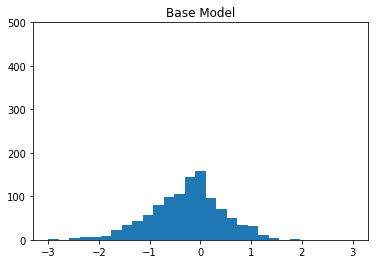

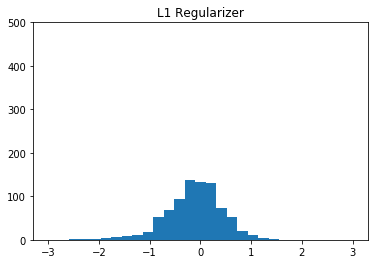

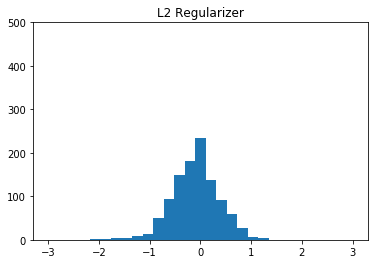

In [109]:
plt.figure()
plt.hist(weights_base, bins=np.linspace(-3,3,30))
plt.title('Base Model')
plt.ylim([0,500])

plt.figure()
plt.hist(weights_l1, bins=np.linspace(-3,3,30))
plt.title('L1 Regularizer')
plt.ylim([0,500])

plt.figure()
plt.hist(weights_l2, bins=np.linspace(-3,3,30))
plt.title('L2 Regularizer')
plt.ylim([0,500])